In this project, I create five machine learning models to predict daily maximum electricity demand in Boston area, and try to understand the role of El Niño-Southern Oscillation (ENSO), North Atlantic Oscillation (NAO) and Pacific–North American (PNA) pattern on the daily maximum electricity demands. First, I start with cleaning and organizing the raw datasets to create an ultimate dataset for my models. 

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
################ Reading raw datasets, selecting data between 2004-2022 and organizing all data in a dataframe ################

#Demand data organization
Demand_2004_2015 = pd.read_excel("Raw_Data/2004_2015_demand.xls", sheet_name="NEMABOS", header=0)
Demand_2016 = pd.read_excel("Raw_Data/2016_demand.xlsx", sheet_name="NEMA", header=0)
Demand_2017 = pd.read_excel("Raw_Data/2017_demand.xlsx", sheet_name="NEMA", header=0)
Demand_2018 = pd.read_excel("Raw_Data/2018_demand.xlsx", sheet_name="NEMA", header=0)
Demand_2019 = pd.read_excel("Raw_Data/2019_demand.xlsx", sheet_name="NEMA", header=0)
Demand_2020 = pd.read_excel("Raw_Data/2020_demand.xlsx", sheet_name="NEMA", header=0)
Demand_2021 = pd.read_excel("Raw_Data/2021_demand.xlsx", sheet_name="NEMA", header=0)
Demand_2022 = pd.read_excel("Raw_Data/2022_demand.xlsx", sheet_name="NEMA", header=0)

All_demand = pd.concat([Demand_2004_2015["PkDEMD"], Demand_2016["Peak_Demand"], Demand_2017["Peak_Demand"], Demand_2018["Peak_Demand"],
                        Demand_2019["Peak_Demand"], Demand_2020["Peak_Demand"], Demand_2021["Peak_Demand"], Demand_2022["Peak_Demand"]], ignore_index=True).values
All_days = pd.concat([Demand_2004_2015["Date"], Demand_2016["Date"], Demand_2017["Date"], Demand_2018["Date"], Demand_2019["Date"],
                      Demand_2020["Date"], Demand_2021["Date"], Demand_2022["Date"]], ignore_index=True).values

#Creating a dataframe to store all organized data
Organized_data = pd.DataFrame({"Date":All_days, "Demand":All_demand})

In [3]:
#Weather data organization
Weather_2004_2013 = pd.read_csv("Raw_Data/Weather_2004_2013.csv", header=0, low_memory=False)
Weather_2004_2013.dropna(subset=["DailyAverageDryBulbTemperature"], inplace=True)

Weather_dates = [pd.to_datetime(i[:10]) for i in Weather_2004_2013["DATE"]]
Weather_2004_2013.index = Weather_dates
Weather_2004_2013 = Weather_2004_2013.reindex(pd.date_range(start="2004-01-01", end="2013-12-31", freq="D"))

Weather_2004_2013["DailyAverageDryBulbTemperature"] = pd.to_numeric(Weather_2004_2013["DailyAverageDryBulbTemperature"], errors='coerce')
Weather_2004_2013["DailyAverageWindSpeed"] = pd.to_numeric(Weather_2004_2013["DailyAverageWindSpeed"], errors='coerce')
Weather_2004_2013["DailyCoolingDegreeDays"] = pd.to_numeric(Weather_2004_2013["DailyCoolingDegreeDays"], errors='coerce')
Weather_2004_2013["DailyHeatingDegreeDays"] = pd.to_numeric(Weather_2004_2013["DailyHeatingDegreeDays"], errors='coerce')

Weather_2004_2013["DailyAverageDryBulbTemperature"] = Weather_2004_2013["DailyAverageDryBulbTemperature"].interpolate(method="linear", limit_direction="both")
Weather_2004_2013["DailyAverageWindSpeed"] = Weather_2004_2013["DailyAverageWindSpeed"].interpolate(method="linear", limit_direction="both")
Weather_2004_2013["DailyCoolingDegreeDays"] = Weather_2004_2013["DailyCoolingDegreeDays"].interpolate(method="linear", limit_direction="both")
Weather_2004_2013["DailyHeatingDegreeDays"] = Weather_2004_2013["DailyHeatingDegreeDays"].interpolate(method="linear", limit_direction="both")

Weather_2014_2022 = pd.read_csv("Raw_Data/Weather_2014_2022.csv", header=0, low_memory=False)
Weather_2014_2022.dropna(subset=["DailyAverageDryBulbTemperature"], inplace=True)

Weather_2014_2022["DailyAverageDryBulbTemperature"] = pd.to_numeric(Weather_2014_2022["DailyAverageDryBulbTemperature"], errors='coerce')
Weather_2014_2022["DailyAverageWindSpeed"] = pd.to_numeric(Weather_2014_2022["DailyAverageWindSpeed"], errors='coerce')
Weather_2014_2022["DailyCoolingDegreeDays"] = pd.to_numeric(Weather_2014_2022["DailyCoolingDegreeDays"], errors='coerce')
Weather_2014_2022["DailyHeatingDegreeDays"] = pd.to_numeric(Weather_2014_2022["DailyHeatingDegreeDays"], errors='coerce')

All_temperature = pd.concat([Weather_2004_2013["DailyAverageDryBulbTemperature"], Weather_2014_2022["DailyAverageDryBulbTemperature"]], ignore_index=True).values
All_wind = pd.concat([Weather_2004_2013["DailyAverageWindSpeed"], Weather_2014_2022["DailyAverageWindSpeed"]], ignore_index=True).values
All_CDD = pd.concat([Weather_2004_2013["DailyCoolingDegreeDays"], Weather_2014_2022["DailyCoolingDegreeDays"]], ignore_index=True).values 
All_HDD = pd.concat([Weather_2004_2013["DailyHeatingDegreeDays"], Weather_2014_2022["DailyHeatingDegreeDays"]], ignore_index=True).values 

Organized_data["Temperature"] = All_temperature
Organized_data["WindSpeed"] = All_wind
Organized_data["CDD"] = All_CDD
Organized_data["HDD"] = All_HDD

In [4]:
#ENSO data organization
ENSO_monthly = pd.read_excel("Raw_Data/ENSO_monthly.xlsx", header=0)
ENSO_monthly = ENSO_monthly.loc[ENSO_monthly["Year"].isin([*range(2004,2023)])]
ENSO_monthly.reset_index(drop=True, inplace=True)

normal_month_days = [31,28,31,30,31,30,31,31,30,31,30,31]
other_month_days = [31,29,31,30,31,30,31,31,30,31,30,31]
month_numbers = [*range(1,13)]

ENSO_monthly["Month"] = month_numbers*19

ENSO_daily = []

for idx, row in ENSO_monthly.iterrows():

    if row["Year"] % 4 == 0:
        days_idx = month_numbers.index(row["Month"])
        ENSO_daily.extend([row["ONI_index"]] * other_month_days[days_idx])

    else:
        days_idx = month_numbers.index(row["Month"])
        ENSO_daily.extend([row["ONI_index"]] * normal_month_days[days_idx])

Organized_data["ENSO_monthly"] = ENSO_daily

In [5]:
#NAO data organization
NAO_monthly = pd.read_excel("Raw_Data/NAO_monthly.xlsx", header=0)
NAO_monthly = NAO_monthly.loc[NAO_monthly["Year"].isin([*range(2004,2023)])]
NAO_monthly.reset_index(drop=True, inplace=True)

NAO_daily_from_month = []

for idx, row in NAO_monthly.iterrows():

    if row["Year"] % 4 == 0:
        days_idx = month_numbers.index(row["Month"])
        NAO_daily_from_month.extend([row["NAO_index"]] * other_month_days[days_idx])

    else:
        days_idx = month_numbers.index(row["Month"])
        NAO_daily_from_month.extend([row["NAO_index"]] * normal_month_days[days_idx])

Organized_data["NAO_monthly"] = NAO_daily_from_month

In [6]:
#PNA data organization
PNA_monthly = pd.read_excel("Raw_Data/PNA_monthly.xlsx", header=0)
PNA_monthly = PNA_monthly.loc[PNA_monthly["Year"].isin([*range(2004,2023)])]
PNA_monthly.reset_index(drop=True, inplace=True)

PNA_daily_from_month = []

for idx, row in PNA_monthly.iterrows():

    if row["Year"] % 4 == 0:
        days_idx = month_numbers.index(row["Month"])
        PNA_daily_from_month.extend([row["PNA_index"]] * other_month_days[days_idx])

    else:
        days_idx = month_numbers.index(row["Month"])
        PNA_daily_from_month.extend([row["PNA_index"]] * normal_month_days[days_idx])

Organized_data["PNA_monthly"] = PNA_daily_from_month

In [7]:
#Adding day, month and day of week and day of year columns
all_data_months = []
all_data_days = []
all_days_of_year = []
day_of_weeks = []
all_data_years = []

for idx, row in Organized_data.iterrows():

    all_data_years.append(row["Date"].year)
    all_data_months.append(row["Date"].month)
    all_data_days.append(row["Date"].day)
    all_days_of_year.append(row["Date"].day_of_year)
    day_of_weeks.append(row["Date"].day_of_week)

Organized_data.insert(1, "Year", all_data_years)
Organized_data.insert(2, "Month", all_data_months)
Organized_data.insert(3, "Day", all_data_days)
Organized_data.insert(4, "DayOfYear", all_days_of_year)
Organized_data.insert(5, "DayOfWeek", day_of_weeks) 
Organized_data["DayOfWeek"] = Organized_data["DayOfWeek"]+1 # 1 = Monday, 7 = Sunday
WeekendWeekday = [0 if (x==6) or (x==7) else 1 for x in Organized_data["DayOfWeek"]]
Organized_data.insert(6, "WeekdayOrWeekend", WeekendWeekday) # 1 = Weekday, 0 = Weekend

In [8]:
#Checking if we have any missing data or not
print(f"Organized dataset has {Organized_data.isna().sum().sum()} missing data.\n")
Organized_data.info()

Organized dataset has 0 missing data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6940 entries, 0 to 6939
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              6940 non-null   datetime64[ns]
 1   Year              6940 non-null   int64         
 2   Month             6940 non-null   int64         
 3   Day               6940 non-null   int64         
 4   DayOfYear         6940 non-null   int64         
 5   DayOfWeek         6940 non-null   int64         
 6   WeekdayOrWeekend  6940 non-null   int64         
 7   Demand            6940 non-null   int64         
 8   Temperature       6940 non-null   float64       
 9   WindSpeed         6940 non-null   float64       
 10  CDD               6940 non-null   float64       
 11  HDD               6940 non-null   float64       
 12  ENSO_monthly      6940 non-null   float64       
 13  NAO_monthly       6940 non-null   float

Now that the dataset is ready with no missing values, let's first start by plotting the correlation coefficients to understand the possible impact of each predictor. 

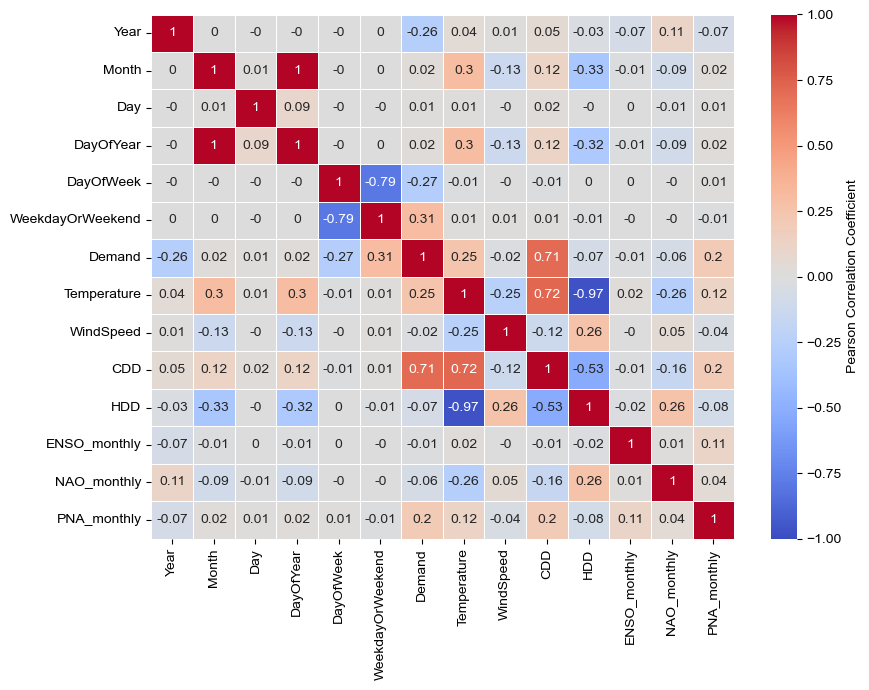

<Figure size 640x480 with 0 Axes>

In [9]:
#Calculating the correlation and plotting it
correlation_matrix = Organized_data.corr(method="pearson", numeric_only=True).round(2)

plt.rcParams.update({'font.size': 10})
plt.rcParams['font.sans-serif'] = "Arial"

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5, annot=True, vmin=-1, vmax=1, cbar_kws={'label': 'Pearson Correlation Coefficient'})
plt.tight_layout()
plt.show()
plt.clf()

It seems like demand is mostly correlated with CDD and weekday or weekend binary predictors. Since Pearson coefficient shows the linear correlation, it is better to plot the possible predictors to see if they have nonlinear relationships with electricity demands. Let's plot some scatter plots, box plots and density plots to understand the impact of each predictor in predicting demand. 

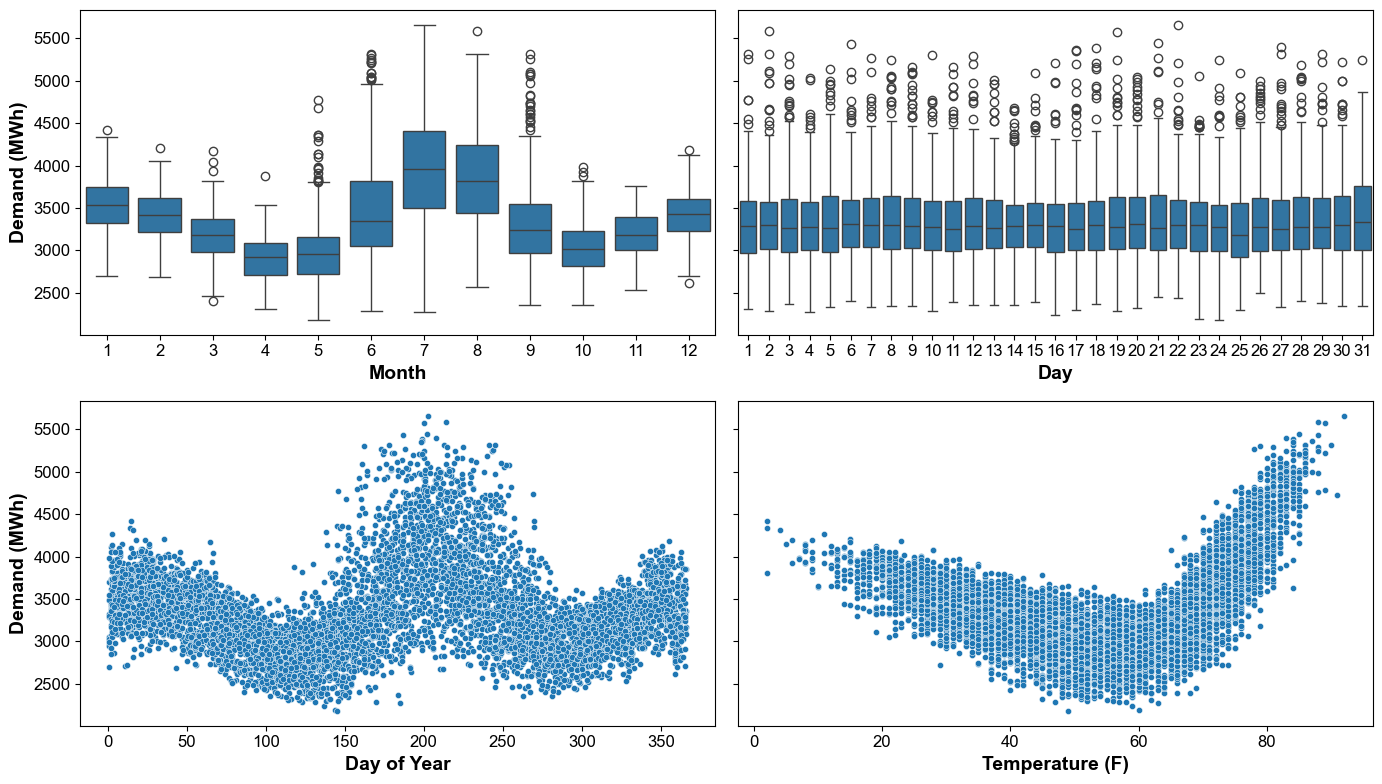

<Figure size 640x480 with 0 Axes>

In [10]:
#Creating scatter and box plots to see distributions
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.sans-serif'] = "Arial"

fig, ax = plt.subplots(2,2, figsize=(14,8), sharey=True)
sns.boxplot(data=Organized_data, x="Month", y="Demand", ax=ax[0,0])
sns.boxplot(data=Organized_data, x="Day", y="Demand", ax=ax[0,1])
sns.scatterplot(data=Organized_data, x="DayOfYear", y="Demand", s=20, ax=ax[1,0])
sns.scatterplot(data=Organized_data, x="Temperature", y="Demand", s=20, ax=ax[1,1])
ax[0,0].set_ylabel("Demand (MWh)", weight='bold', fontsize=14)
ax[1,0].set_ylabel("Demand (MWh)", weight='bold', fontsize=14)
ax[0,0].set_xlabel("Month", weight='bold', fontsize=14)
ax[0,1].set_xlabel("Day", weight='bold', fontsize=14)
ax[1,0].set_xlabel("Day of Year", weight='bold', fontsize=14)
ax[1,1].set_xlabel("Temperature (F)", weight='bold', fontsize=14)
plt.tight_layout()
plt.show()
plt.clf()

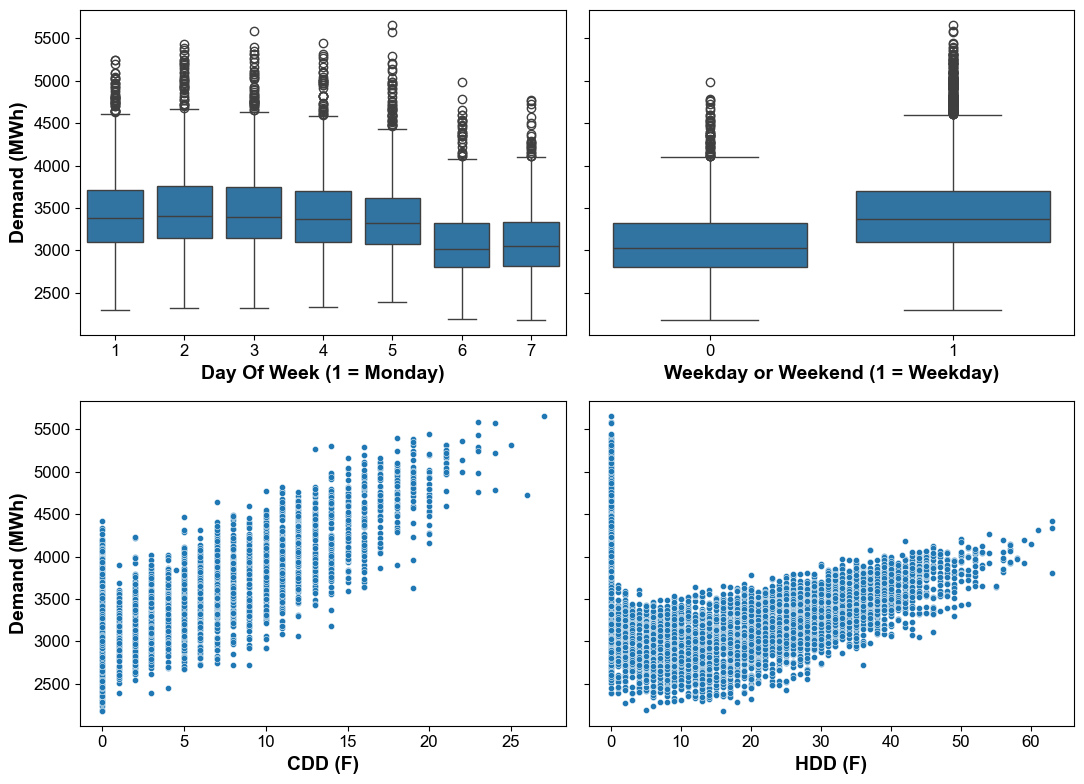

<Figure size 640x480 with 0 Axes>

In [11]:
#Creating scatter and box plots to see distributions
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.sans-serif'] = "Arial"

fig, ax = plt.subplots(2,2, figsize=(11,8), sharey=True)
sns.boxplot(data=Organized_data, x="DayOfWeek", y="Demand", ax=ax[0,0])
sns.boxplot(data=Organized_data, x="WeekdayOrWeekend", y="Demand", ax=ax[0,1])
sns.scatterplot(data=Organized_data, x="CDD", y="Demand", s=20, ax=ax[1,0])
sns.scatterplot(data=Organized_data, x="HDD", y="Demand", s=20, ax=ax[1,1])
ax[0,0].set_ylabel("Demand (MWh)", weight='bold', fontsize=14)
ax[1,0].set_ylabel("Demand (MWh)", weight='bold', fontsize=14)
ax[0,0].set_xlabel("Day Of Week (1 = Monday)", weight='bold', fontsize=14)
ax[0,1].set_xlabel("Weekday or Weekend (1 = Weekday)", weight='bold', fontsize=14)
ax[1,0].set_xlabel("CDD (F)", weight='bold', fontsize=14)
ax[1,1].set_xlabel("HDD (F)", weight='bold', fontsize=14)
plt.tight_layout()
plt.show()
plt.clf()

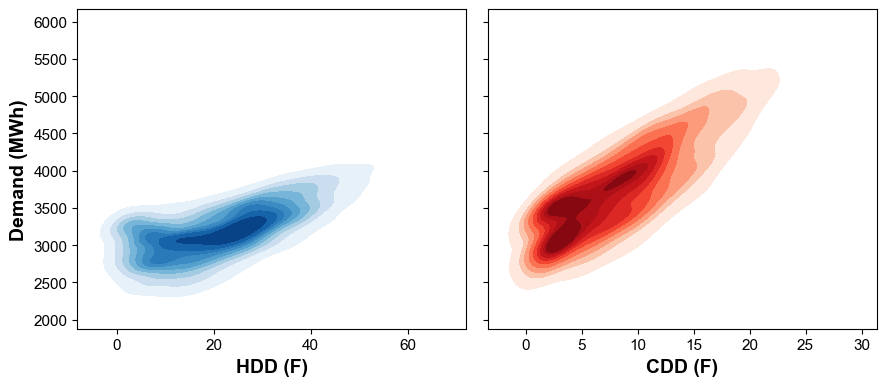

<Figure size 640x480 with 0 Axes>

In [12]:
#Creating density plots to see distributions
plt.rcParams.update({'font.size': 11})
plt.rcParams['font.sans-serif'] = "Arial"

fig, ax = plt.subplots(1,2, figsize=(9,4), sharey=True)
sns.kdeplot(data=Organized_data.loc[Organized_data["HDD"]>0], x="HDD", y="Demand", fill=True, cmap="Blues", ax=ax[0])
sns.kdeplot(data=Organized_data.loc[Organized_data["CDD"]>0], x="CDD", y="Demand", fill=True, cmap="Reds", ax=ax[1])
ax[0].set_ylabel("Demand (MWh)", weight='bold', fontsize=14)
ax[0].set_xlabel("HDD (F)", weight='bold', fontsize=14)
ax[1].set_xlabel("CDD (F)", weight='bold', fontsize=14)
plt.tight_layout()
plt.show()
plt.clf()

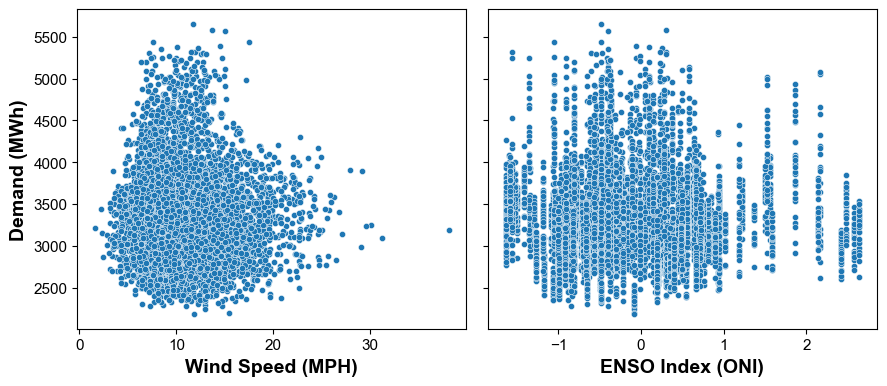

<Figure size 640x480 with 0 Axes>

In [13]:
#Creating scatter and box plots to see distributions
plt.rcParams.update({'font.size': 11})
plt.rcParams['font.sans-serif'] = "Arial"

fig, ax = plt.subplots(1,2, figsize=(9,4), sharey=True)
sns.scatterplot(data=Organized_data, x="WindSpeed", y="Demand", s=20, ax=ax[0])
sns.scatterplot(data=Organized_data, x="ENSO_monthly", y="Demand", s=20, ax=ax[1])
ax[0].set_ylabel("Demand (MWh)", weight='bold', fontsize=14)
ax[0].set_xlabel("Wind Speed (MPH)", weight='bold', fontsize=14)
ax[1].set_xlabel("ENSO Index (ONI)", weight='bold', fontsize=14)
plt.tight_layout()
plt.show()
plt.clf()

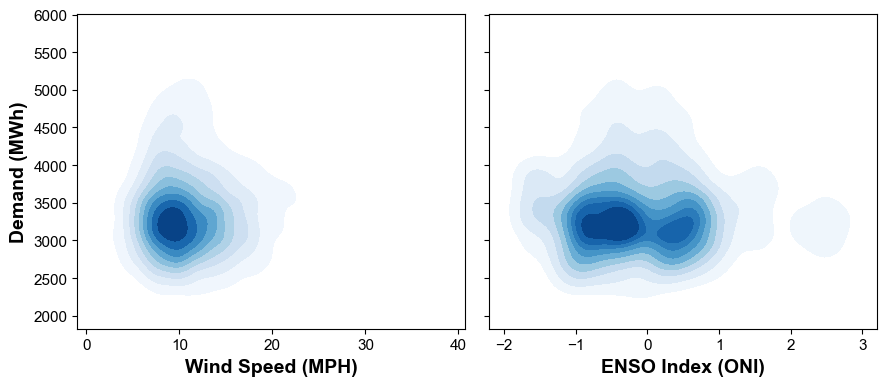

<Figure size 640x480 with 0 Axes>

In [14]:
#Creating density plots to see distributions
plt.rcParams.update({'font.size': 11})
plt.rcParams['font.sans-serif'] = "Arial"

fig, ax = plt.subplots(1,2, figsize=(9,4), sharey=True)
sns.kdeplot(data=Organized_data, x="WindSpeed", y="Demand", fill=True, cmap="Blues", ax=ax[0])
sns.kdeplot(data=Organized_data, x="ENSO_monthly", y="Demand", fill=True, cmap="Blues", ax=ax[1])
ax[0].set_ylabel("Demand (MWh)", weight='bold', fontsize=14)
ax[0].set_xlabel("Wind Speed (MPH)", weight='bold', fontsize=14)
ax[1].set_xlabel("ENSO Index (ONI)", weight='bold', fontsize=14)
plt.tight_layout()
plt.show()
plt.clf()

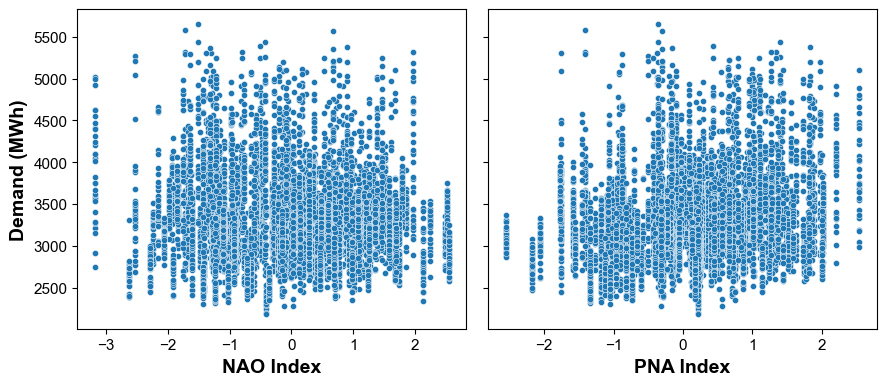

<Figure size 640x480 with 0 Axes>

In [15]:
#Creating scatter and box plots to see distributions
plt.rcParams.update({'font.size': 11})
plt.rcParams['font.sans-serif'] = "Arial"

fig, ax = plt.subplots(1,2, figsize=(9,4), sharey=True)
sns.scatterplot(data=Organized_data, x="NAO_monthly", y="Demand", s=20, ax=ax[0])
sns.scatterplot(data=Organized_data, x="PNA_monthly", y="Demand", s=20, ax=ax[1])
ax[0].set_ylabel("Demand (MWh)", weight='bold', fontsize=14)
ax[0].set_xlabel("NAO Index", weight='bold', fontsize=14)
ax[1].set_xlabel("PNA Index", weight='bold', fontsize=14)
plt.tight_layout()
plt.show()
plt.clf()

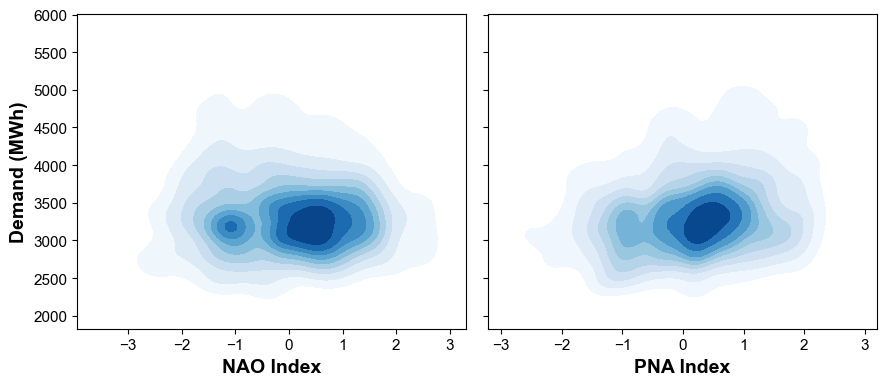

<Figure size 640x480 with 0 Axes>

In [16]:
#Creating density plots to see distributions
plt.rcParams.update({'font.size': 11})
plt.rcParams['font.sans-serif'] = "Arial"

fig, ax = plt.subplots(1,2, figsize=(9,4), sharey=True)
sns.kdeplot(data=Organized_data, x="NAO_monthly", y="Demand", fill=True, cmap="Blues", ax=ax[0])
sns.kdeplot(data=Organized_data, x="PNA_monthly", y="Demand", fill=True, cmap="Blues", ax=ax[1])
ax[0].set_ylabel("Demand (MWh)", weight='bold', fontsize=14)
ax[0].set_xlabel("NAO Index", weight='bold', fontsize=14)
ax[1].set_xlabel("PNA Index", weight='bold', fontsize=14)
plt.tight_layout()
plt.show()
plt.clf()

In [17]:
#Adding new columns for ENSO conditions
ENSO_conditions = []
ENSO_codes = []

for idx, row in Organized_data.iterrows():

    if row["ENSO_monthly"] >= 0.5:
        ENSO_conditions.append("El Nino")
        ENSO_codes.append(2)

    elif row["ENSO_monthly"] <= -0.5:
        ENSO_conditions.append("La Nina")
        ENSO_codes.append(1)

    else:
        ENSO_conditions.append("Neutral")
        ENSO_codes.append(0)

Organized_data["ENSO_condition"] = ENSO_conditions
Organized_data["ENSO_code"] = ENSO_codes

#Adding new columns for NAO conditions
NAO_conditions = []
NAO_codes = []

for idx, row in Organized_data.iterrows():

    if row["NAO_monthly"] >= 0:
        NAO_conditions.append("Positive")
        NAO_codes.append(1)

    else:
        NAO_conditions.append("Negative")
        NAO_codes.append(0)

Organized_data["NAO_condition"] = NAO_conditions
Organized_data["NAO_code"] = NAO_codes

#Adding new columns for PNA conditions
PNA_conditions = []
PNA_codes = []

for idx, row in Organized_data.iterrows():

    if row["PNA_monthly"] >= 0:
        PNA_conditions.append("Positive")
        PNA_codes.append(1)

    else:
        PNA_conditions.append("Negative")
        PNA_codes.append(0)

Organized_data["PNA_condition"] = PNA_conditions
Organized_data["PNA_code"] = PNA_codes

In [18]:
#Adding new columns for HDD and CDD wind speeds
Wind_HDD = [0 if x == 0 else Organized_data.loc[ind,"WindSpeed"] for ind, x in enumerate(Organized_data["HDD"])]
Wind_CDD = [0 if x == 0 else Organized_data.loc[ind,"WindSpeed"] for ind, x in enumerate(Organized_data["CDD"])]

Organized_data["WindSpeed_HDD"] = Wind_HDD
Organized_data["WindSpeed_CDD"] = Wind_CDD

In [19]:
#Saving the dataset and looking at final version of the data
Organized_data.to_csv("Organized_Data/Demand_prediction_organized_dataset.csv", index=False)
Organized_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6940 entries, 0 to 6939
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              6940 non-null   datetime64[ns]
 1   Year              6940 non-null   int64         
 2   Month             6940 non-null   int64         
 3   Day               6940 non-null   int64         
 4   DayOfYear         6940 non-null   int64         
 5   DayOfWeek         6940 non-null   int64         
 6   WeekdayOrWeekend  6940 non-null   int64         
 7   Demand            6940 non-null   int64         
 8   Temperature       6940 non-null   float64       
 9   WindSpeed         6940 non-null   float64       
 10  CDD               6940 non-null   float64       
 11  HDD               6940 non-null   float64       
 12  ENSO_monthly      6940 non-null   float64       
 13  NAO_monthly       6940 non-null   float64       
 14  PNA_monthly       6940 n

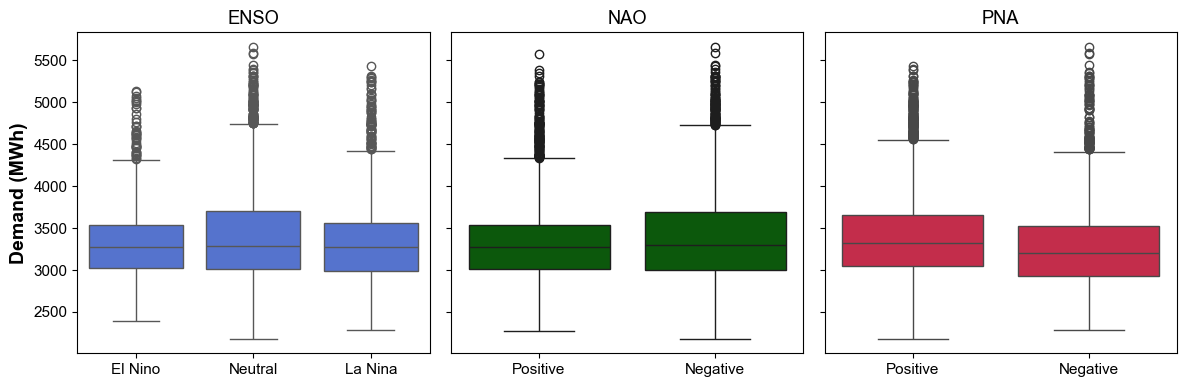

<Figure size 640x480 with 0 Axes>

In [20]:
#Plotting demands with respect to ENSO, NAO and PNA conditions
plt.rcParams.update({'font.size': 11})
plt.rcParams['font.sans-serif'] = "Arial"

fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)
sns.boxplot(data=Organized_data, x="ENSO_condition", y="Demand", order=["El Nino", "Neutral", "La Nina"], color="royalblue", ax=ax[0])
sns.boxplot(data=Organized_data, x="NAO_condition", y="Demand", order=["Positive", "Negative"], color="darkgreen", ax=ax[1])
sns.boxplot(data=Organized_data, x="PNA_condition", y="Demand", order=["Positive", "Negative"], color="crimson", ax=ax[2])

ax[0].set_ylabel("Demand (MWh)", weight='bold', fontsize=14)
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[2].set_xlabel("")

ax[0].set_title("ENSO")
ax[1].set_title("NAO")
ax[2].set_title("PNA")
plt.tight_layout()
plt.show()
plt.clf()


From the plot above, it does not seem like there is a strong relationship between daily maximum demands and ENSO, NAO and PNA conditions. We can see only minimal effects. One noticeable effect is from PNA, where positive phases increase the electricity demand compared to negative phases. 

Now, I am building machine learning models and comparing accuracies in predicting daily maximum demand. First, I am not using ENSO, NAO and PNA indices and will add them after I select the best model. 

In [21]:
Organized_data.columns

Index(['Date', 'Year', 'Month', 'Day', 'DayOfYear', 'DayOfWeek',
       'WeekdayOrWeekend', 'Demand', 'Temperature', 'WindSpeed', 'CDD', 'HDD',
       'ENSO_monthly', 'NAO_monthly', 'PNA_monthly', 'ENSO_condition',
       'ENSO_code', 'NAO_condition', 'NAO_code', 'PNA_condition', 'PNA_code',
       'WindSpeed_HDD', 'WindSpeed_CDD'],
      dtype='object')

By considering the analytics we have so far, I have used day of year, binary weekday or weekend, wind speed, CDD, and HDD as predictors. 

In [22]:
#Defining the predictors and target variable
predictors = Organized_data[['DayOfYear', 'WeekdayOrWeekend', 'WindSpeed', 'CDD', 'HDD']]
target = Organized_data['Demand']

In [23]:
########################### Multiple Linear Regression ###########################

#Initializing TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

#Initializing metrics lists
RMSE_all = []
R2_all = []
MAE_all = []

#Initializing RobustScaler
scaler = RobustScaler()

#Iterating over the splits
for train_index, test_index in tscv.split(predictors):
    X_train, X_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    #Scaling the predictors via RobustScaler
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Initializing and fitting the multiple linear regression model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    #Making predictions
    y_pred = model.predict(X_test_scaled)

    #Calculating and appending metrics
    model_RMSE = mean_squared_error(y_test, y_pred, squared=False)
    model_R2 = r2_score(y_test, y_pred)
    model_MAE = mean_absolute_error(y_test, y_pred)

    RMSE_all.append(model_RMSE)
    R2_all.append(model_R2)
    MAE_all.append(model_MAE)

#Calculating mean of the metrics
mean_RMSE = np.mean(RMSE_all)
mean_R2 = np.mean(R2_all)
mean_MAE = np.mean(MAE_all)

print(f'Mean RMSE: {round(mean_RMSE,4)}')
print(f'Mean R-squared: {round(mean_R2,4)}')
print(f'Mean MAE: {round(mean_MAE,4)}')

Mean RMSE: 275.8292
Mean R-squared: 0.6812
Mean MAE: 227.7214


In [24]:
########################### Polynomial Regression ###########################

#Initializing TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

#Initializing metrics lists
RMSE_all = []
R2_all = []
MAE_all = []

#Iterating over the splits
for train_index, test_index in tscv.split(predictors):
    X_train, X_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    #Creating a pipeline with RobustScaler, PolynomialFeatures, and LinearRegression
    model = make_pipeline(RobustScaler(), PolynomialFeatures(), LinearRegression())

    # Hyperparameter grid for PolynomialFeatures
    param_grid = {'polynomialfeatures__degree': [2, 3, 4]}

    #Initializing GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')

    #Fitting the model
    grid_search.fit(X_train, y_train)

    #Making predictions
    y_pred = grid_search.predict(X_test)

    #Calculating and appending metrics
    model_RMSE = mean_squared_error(y_test, y_pred, squared=False)
    model_R2 = r2_score(y_test, y_pred)
    model_MAE = mean_absolute_error(y_test, y_pred)

    RMSE_all.append(model_RMSE)
    R2_all.append(model_R2)
    MAE_all.append(model_MAE)

#Getting the best degree from hyperparameter tuning
best_degree = grid_search.best_params_['polynomialfeatures__degree']

#Calculating mean of the metrics
mean_RMSE = np.mean(RMSE_all)
mean_R2 = np.mean(R2_all)
mean_MAE = np.mean(MAE_all)

print(f'Mean RMSE: {round(mean_RMSE,4)}')
print(f'Mean R-squared: {round(mean_R2,4)}')
print(f'Mean MAE: {round(mean_MAE,4)}')
print(f'Best polynomial degree: {best_degree}')

Mean RMSE: 246.5397
Mean R-squared: 0.7397
Mean MAE: 204.8179
Best polynomial degree: 3


In [25]:
########################### Support Vector Regression ###########################

#Initializing TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

#Initializing metrics lists
RMSE_all = []
R2_all = []
MAE_all = []

#Iterating over the splits
for train_index, test_index in tscv.split(predictors):
    X_train, X_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    #Creating a pipeline with RobustScaler and SVR
    model = make_pipeline(RobustScaler(),SVR())

    #Hyperparameter grid for SVR
    param_grid = {
        'svr__C': [0.1, 1, 10],             
        'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],   
        'svr__gamma': ['scale', 'auto'],
        'svr__degree': [2, 3, 4],
        'svr__epsilon': [0.1, 0.2, 0.3],
        'svr__coef0': [0, 1, 2]
    }

    #Initializing GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')

    #Fitting the model
    grid_search.fit(X_train, y_train)

    #Making predictions
    y_pred = grid_search.predict(X_test)

    #Calculating and appending metrics
    model_RMSE = mean_squared_error(y_test, y_pred, squared=False)
    model_R2 = r2_score(y_test, y_pred)
    model_MAE = mean_absolute_error(y_test, y_pred)

    RMSE_all.append(model_RMSE)
    R2_all.append(model_R2)
    MAE_all.append(model_MAE)

#Getting the best degree from hyperparameter tuning
best_params = grid_search.best_params_

#Calculating mean of the metrics
mean_RMSE = np.mean(RMSE_all)
mean_R2 = np.mean(R2_all)
mean_MAE = np.mean(MAE_all)

print(f'Mean RMSE: {round(mean_RMSE,4)}')
print(f'Mean R-squared: {round(mean_R2,4)}')
print(f'Mean MAE: {round(mean_MAE,4)}')
print(f'Best hyperparameters: {best_params}')

Mean RMSE: 257.9481
Mean R-squared: 0.7145
Mean MAE: 216.4249
Best hyperparameters: {'svr__C': 10, 'svr__coef0': 2, 'svr__degree': 4, 'svr__epsilon': 0.1, 'svr__gamma': 'auto', 'svr__kernel': 'poly'}


In [27]:
########################### Random Forest Regression ###########################

#Initializing TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

#Initializing metrics lists
RMSE_all = []
R2_all = []
MAE_all = []

#Iterating over the splits
for train_index, test_index in tscv.split(predictors):
    X_train, X_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    #Hyperparameter grid for Random Forest
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_features': [None, 'sqrt', 'log2'],  
        'max_depth': [None, 10, 20, 30, 50],       
        'min_samples_split': [2, 5, 10, 20],       
        'min_samples_leaf': [1, 2, 4],         
        'bootstrap': [True, False]
    }

    #Initializing Random Forest Regressor
    rf = RandomForestRegressor()

    #Initializing RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='neg_mean_squared_error')

    #Fitting the model
    random_search.fit(X_train, y_train)

    #Making predictions
    y_pred = random_search.predict(X_test)

    #Calculating and appending metrics
    model_RMSE = mean_squared_error(y_test, y_pred, squared=False)
    model_R2 = r2_score(y_test, y_pred)
    model_MAE = mean_absolute_error(y_test, y_pred)

    RMSE_all.append(model_RMSE)
    R2_all.append(model_R2)
    MAE_all.append(model_MAE)

#Getting the best degree from hyperparameter tuning
best_params = random_search.best_params_

#Calculating mean of the metrics
mean_RMSE = np.mean(RMSE_all)
mean_R2 = np.mean(R2_all)
mean_MAE = np.mean(MAE_all)

print(f'Mean RMSE: {round(mean_RMSE,4)}')
print(f'Mean R-squared: {round(mean_R2,4)}')
print(f'Mean MAE: {round(mean_MAE,4)}')
print(f'Best hyperparameters: {best_params}')

Mean RMSE: 242.2976
Mean R-squared: 0.7445
Mean MAE: 201.7159
Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 50, 'bootstrap': True}


In [23]:
########################### Gradient Boosting Regression ###########################

#Initializing TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

#Initializing metrics lists
RMSE_all = []
R2_all = []
MAE_all = []

#Iterating over the splits
for train_index, test_index in tscv.split(predictors):
    X_train, X_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    #Hyperparameter grid for Gradient Boosting
    param_grid = {
        'n_estimators': [50, 100, 200],         
        'learning_rate': [0.01, 0.1, 0.2],      
        'max_depth': [3, 4, 5],                 
        'min_samples_split': [2, 5, 10],       
        'min_samples_leaf': [1, 2, 4],
    }

    #Initializing Gradient Boosting Regressor
    gb = GradientBoostingRegressor()

    #Initializing GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(gb, param_grid, cv=tscv, scoring='neg_mean_squared_error')

    #Fitting the model
    grid_search.fit(X_train, y_train)

    #Making predictions
    y_pred = grid_search.predict(X_test)

    #Calculating and appending metrics
    model_RMSE = mean_squared_error(y_test, y_pred, squared=False)
    model_R2 = r2_score(y_test, y_pred)
    model_MAE = mean_absolute_error(y_test, y_pred)

    RMSE_all.append(model_RMSE)
    R2_all.append(model_R2)
    MAE_all.append(model_MAE)

#Getting the best degree from hyperparameter tuning
best_params = grid_search.best_params_

#Calculating mean of the metrics
mean_RMSE = np.mean(RMSE_all)
mean_R2 = np.mean(R2_all)
mean_MAE = np.mean(MAE_all)

print(f'Mean RMSE: {round(mean_RMSE,4)}')
print(f'Mean R-squared: {round(mean_R2,4)}')
print(f'Mean MAE: {round(mean_MAE,4)}')
print(f'Best hyperparameters: {best_params}')


Mean RMSE: 234.3157
Mean R-squared: 0.7589
Mean MAE: 197.2968
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


Since Gradient Boosting Regressor gave the best results and came out to be most accurate, I am selecting it as the possible best model. Lastly, I will compare the impact of ENSO, NAO and PNA by including/excluding them in the model and checking metrics. 

In [26]:
#Creating a function for GradientBoostingRegressor
def DailyDemandModel(my_seed, predictors, target, best_params):

    # Set the random seed
    np.random.seed(my_seed)

    # Initialize TimeSeriesSplit with 5 splits
    tscv = TimeSeriesSplit(n_splits=5)

    #Initializing metrics lists
    RMSE_all = []
    R2_all = []
    MAE_all = []

    #List to store feature importance
    feature_importances_list = []

    #Initializing the GradientBoostingRegressor with the best hyperparameters
    gb_model = GradientBoostingRegressor(random_state=my_seed, **best_params)

    #Iterating over the splits
    for train_index, test_index in tscv.split(predictors):
        X_train, X_test = predictors.iloc[train_index], predictors.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        #Fitting the model
        gb_model.fit(X_train, y_train)

        #Making predictions
        y_pred = gb_model.predict(X_test)

        #Calculating and appending metrics
        model_RMSE = mean_squared_error(y_test, y_pred, squared=False)
        model_R2 = r2_score(y_test, y_pred)
        model_MAE = mean_absolute_error(y_test, y_pred)

        RMSE_all.append(model_RMSE)
        R2_all.append(model_R2)
        MAE_all.append(model_MAE)

        #Appending feature importances to the list
        feature_importances_list.append(gb_model.feature_importances_)

    #Calculating mean of the metrics
    mean_RMSE = np.mean(RMSE_all)
    mean_R2 = np.mean(R2_all)
    mean_MAE = np.mean(MAE_all)

    #Calculating mean feature importances across splits
    mean_feature_importances = np.mean(feature_importances_list, axis=0)

    #Getting the names of the predictors
    predictor_names = predictors.columns

    #Sorting the features by importance
    sorted_idx = np.argsort(mean_feature_importances)

    #Printing the metrics
    print(f'Mean RMSE: {round(mean_RMSE,4)}')
    print(f'Mean R-squared: {round(mean_R2,4)}')
    print(f'Mean MAE: {round(mean_MAE,4)}')

    #Plotting the relative importance of features
    plt.rcParams.update({'font.size': 11})
    plt.rcParams['font.sans-serif'] = "Arial"

    fig, ax = plt.subplots(figsize=(7,5))

    ax.barh(range(len(predictor_names)), mean_feature_importances[sorted_idx], align="center")
    ax.set_yticks(range(len(predictor_names)), [predictor_names[i] for i in sorted_idx])
    ax.set_xlabel("Mean Relative Feature Importance")
    ax.set_title("Feature Importance")
    plt.tight_layout()
    plt.show()
    plt.clf()

    return mean_RMSE, mean_R2, mean_MAE

Mean RMSE: 234.3239
Mean R-squared: 0.7589
Mean MAE: 197.2945


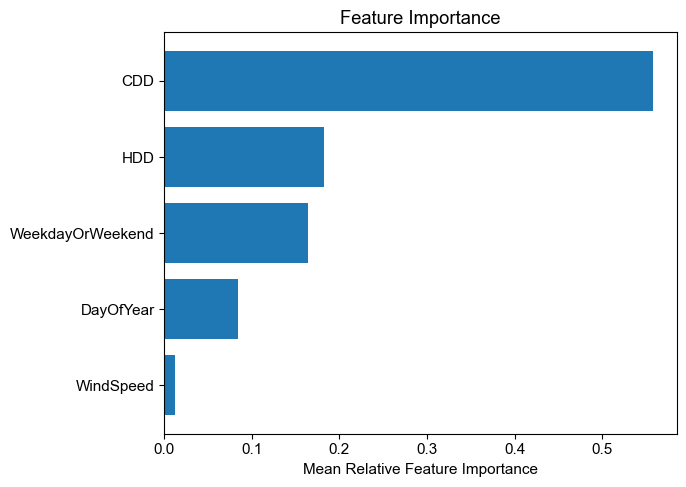

<Figure size 640x480 with 0 Axes>

In [27]:
########################## DEFAULT GradientBoostingRegressor ##########################

#Defining the predictors and target variable
predictors = Organized_data[['DayOfYear', 'WeekdayOrWeekend', 'WindSpeed', 'CDD', 'HDD']]
target = Organized_data['Demand']

#Defining the best parameters
best_params = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}

#Calling our model to report metrics and plot the feature importance figure
my_RMSE, my_R2, my_MAE = DailyDemandModel(12345, predictors, target, best_params)

Mean RMSE: 241.5114
Mean R-squared: 0.7417
Mean MAE: 203.5071


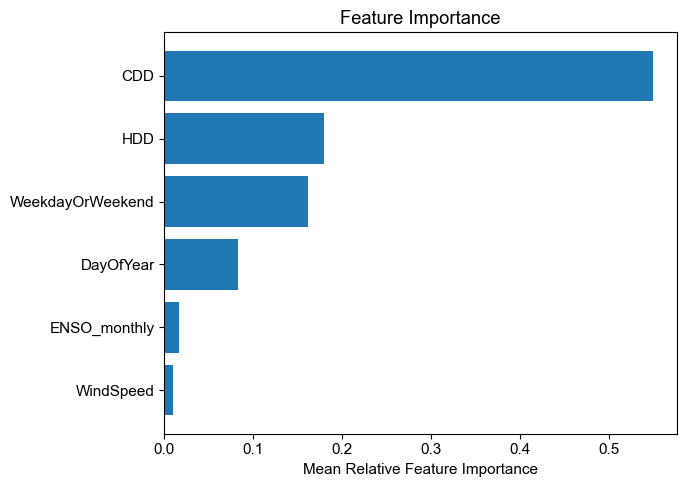

<Figure size 640x480 with 0 Axes>

In [28]:
########################## GradientBoostingRegressor with ENSO index ##########################

#Defining the predictors and target variable
predictors = Organized_data[['DayOfYear', 'WeekdayOrWeekend', 'WindSpeed', 'CDD', 'HDD', 'ENSO_monthly']]
target = Organized_data['Demand']

#Defining the best parameters
best_params = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}

#Calling our model to report metrics and plot the feature importance figure
my_RMSE, my_R2, my_MAE = DailyDemandModel(12345, predictors, target, best_params)

Mean RMSE: 237.7899
Mean R-squared: 0.7498
Mean MAE: 200.9208


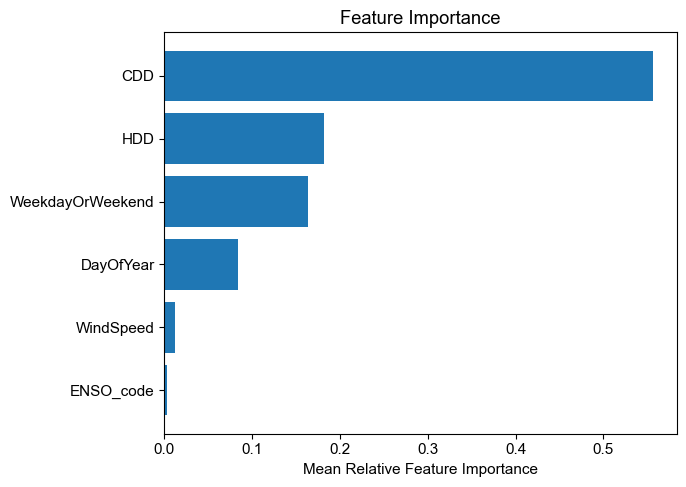

<Figure size 640x480 with 0 Axes>

In [29]:
########################## GradientBoostingRegressor with ENSO Code ##########################

#Defining the predictors and target variable
predictors = Organized_data[['DayOfYear', 'WeekdayOrWeekend', 'WindSpeed', 'CDD', 'HDD', 'ENSO_code']]
target = Organized_data['Demand']

#Defining the best parameters
best_params = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}

#Calling our model to report metrics and plot the feature importance figure
my_RMSE, my_R2, my_MAE = DailyDemandModel(12345, predictors, target, best_params)

Mean RMSE: 241.6455
Mean R-squared: 0.7415
Mean MAE: 203.2056


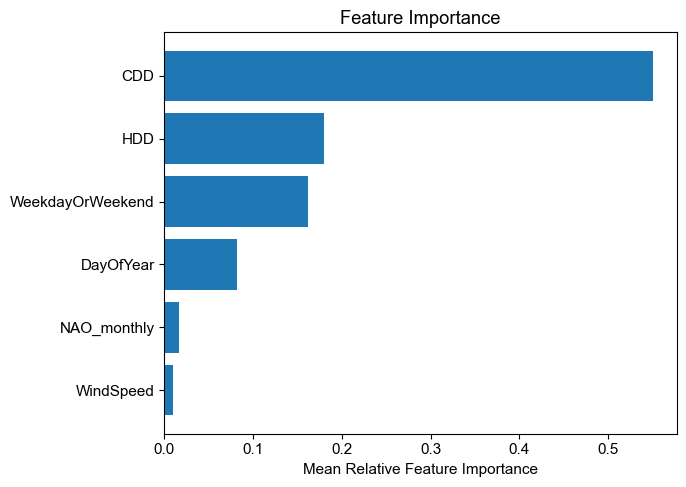

<Figure size 640x480 with 0 Axes>

In [30]:
########################## GradientBoostingRegressor with NAO Index ##########################

#Defining the predictors and target variable
predictors = Organized_data[['DayOfYear', 'WeekdayOrWeekend', 'WindSpeed', 'CDD', 'HDD', 'NAO_monthly']]
target = Organized_data['Demand']

#Defining the best parameters
best_params = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}

#Calling our model to report metrics and plot the feature importance figure
my_RMSE, my_R2, my_MAE = DailyDemandModel(12345, predictors, target, best_params)

Mean RMSE: 235.6248
Mean R-squared: 0.7557
Mean MAE: 198.0571


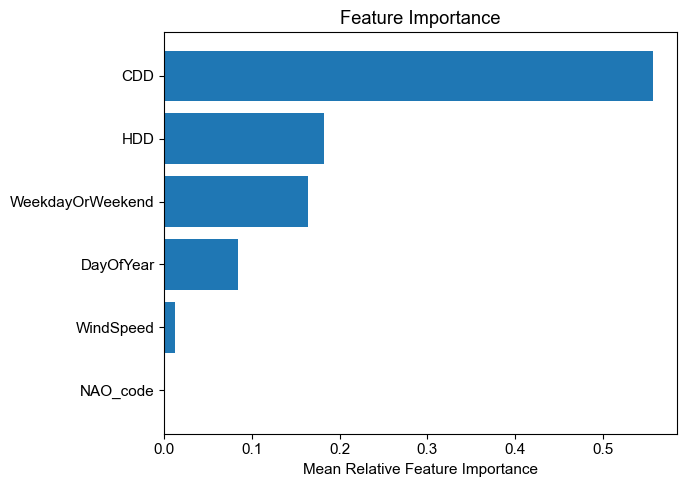

<Figure size 640x480 with 0 Axes>

In [31]:
########################## GradientBoostingRegressor with NAO Code ##########################

#Defining the predictors and target variable
predictors = Organized_data[['DayOfYear', 'WeekdayOrWeekend', 'WindSpeed', 'CDD', 'HDD', 'NAO_code']]
target = Organized_data['Demand']

#Defining the best parameters
best_params = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}

#Calling our model to report metrics and plot the feature importance figure
my_RMSE, my_R2, my_MAE = DailyDemandModel(12345, predictors, target, best_params)

Mean RMSE: 237.3559
Mean R-squared: 0.7548
Mean MAE: 198.7949


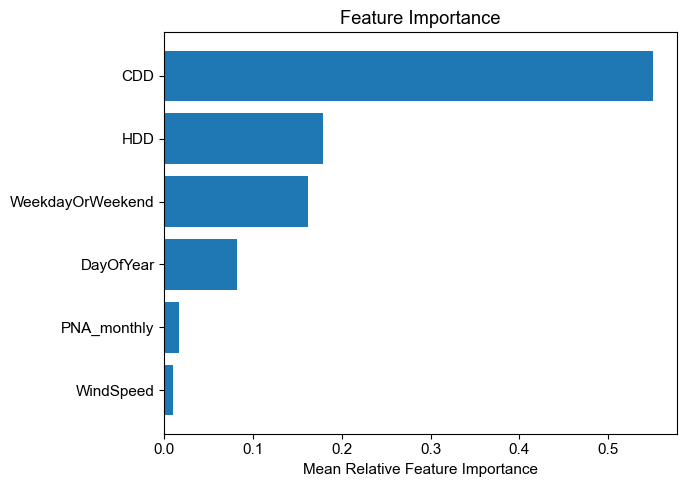

<Figure size 640x480 with 0 Axes>

In [32]:
########################## GradientBoostingRegressor with PNA Index ##########################

#Defining the predictors and target variable
predictors = Organized_data[['DayOfYear', 'WeekdayOrWeekend', 'WindSpeed', 'CDD', 'HDD', 'PNA_monthly']]
target = Organized_data['Demand']

#Defining the best parameters
best_params = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}

#Calling our model to report metrics and plot the feature importance figure
my_RMSE, my_R2, my_MAE = DailyDemandModel(12345, predictors, target, best_params)

Mean RMSE: 233.8075
Mean R-squared: 0.7604
Mean MAE: 196.6427


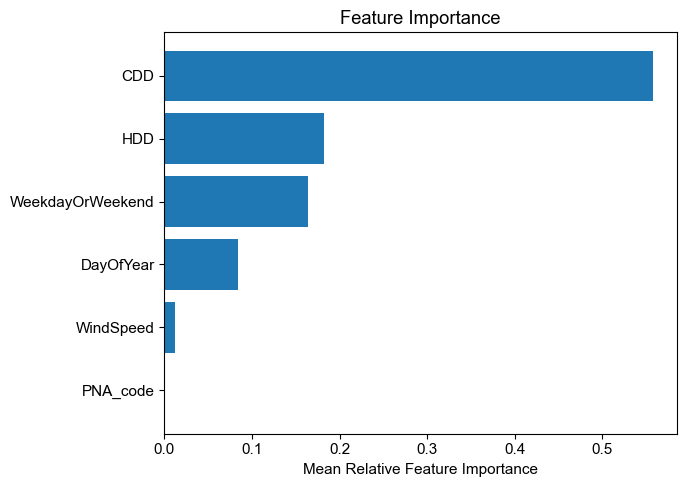

<Figure size 640x480 with 0 Axes>

In [33]:
########################## GradientBoostingRegressor with PNA Code ##########################

#Defining the predictors and target variable
predictors = Organized_data[['DayOfYear', 'WeekdayOrWeekend', 'WindSpeed', 'CDD', 'HDD', 'PNA_code']]
target = Organized_data['Demand']

#Defining the best parameters
best_params = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}

#Calling our model to report metrics and plot the feature importance figure
my_RMSE, my_R2, my_MAE = DailyDemandModel(12345, predictors, target, best_params)

Mean RMSE: 243.036
Mean R-squared: 0.7399
Mean MAE: 204.126


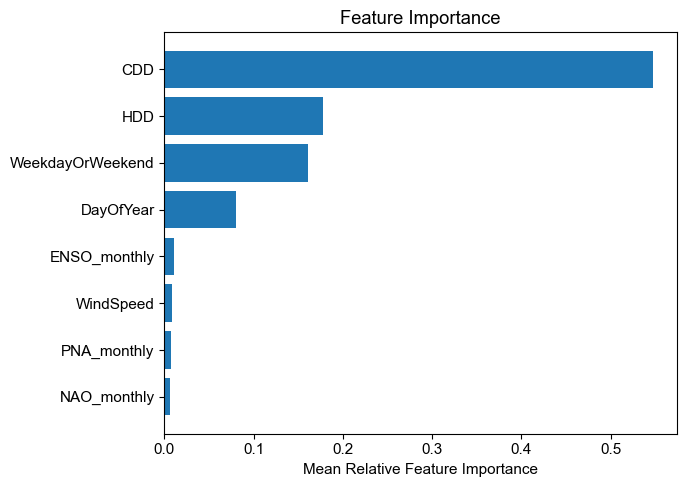

<Figure size 640x480 with 0 Axes>

In [34]:
########################## GradientBoostingRegressor with ENSO, NAO, PNA Index ##########################

#Defining the predictors and target variable
predictors = Organized_data[['DayOfYear', 'WeekdayOrWeekend', 'WindSpeed', 'CDD', 'HDD', 'ENSO_monthly', 'NAO_monthly', 'PNA_monthly',]]
target = Organized_data['Demand']

#Defining the best parameters
best_params = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}

#Calling our model to report metrics and plot the feature importance figure
my_RMSE, my_R2, my_MAE = DailyDemandModel(12345, predictors, target, best_params)

Mean RMSE: 238.5922
Mean R-squared: 0.7487
Mean MAE: 201.089


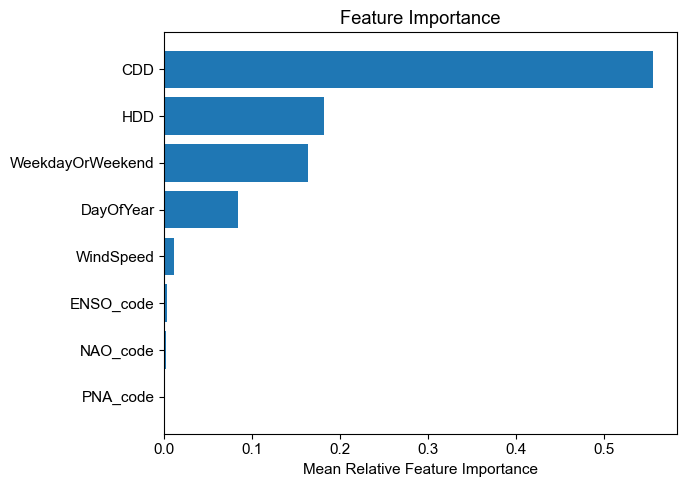

<Figure size 640x480 with 0 Axes>

In [35]:
########################## GradientBoostingRegressor with ENSO, NAO, PNA Code ##########################

#Defining the predictors and target variable
predictors = Organized_data[['DayOfYear', 'WeekdayOrWeekend', 'WindSpeed', 'CDD', 'HDD', 'ENSO_code', 'NAO_code', 'PNA_code',]]
target = Organized_data['Demand']

#Defining the best parameters
best_params = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}

#Calling our model to report metrics and plot the feature importance figure
my_RMSE, my_R2, my_MAE = DailyDemandModel(12345, predictors, target, best_params)

As we can see, adding ENSO, NAO, PNA conditions or indices did not help with the daily demand predictions and sometimes made the accuracy metrics even worse. Out of all combinations, only PNA phase increased the demand prediction accuracy but minimally. Thus, these climate patterns do not seem to be helpful in estimating daily maximum electricity demand. Since ENSO, NAO and PNA indices are monthly, I also tried to estimate monthly electricity demand with the same GradientBoostingRegressor model but again those climate indices did not help with the demand estimations even on a monthly demand scale.

Lastly, I will plot a figure to compare our demand estimations with the historical values. 

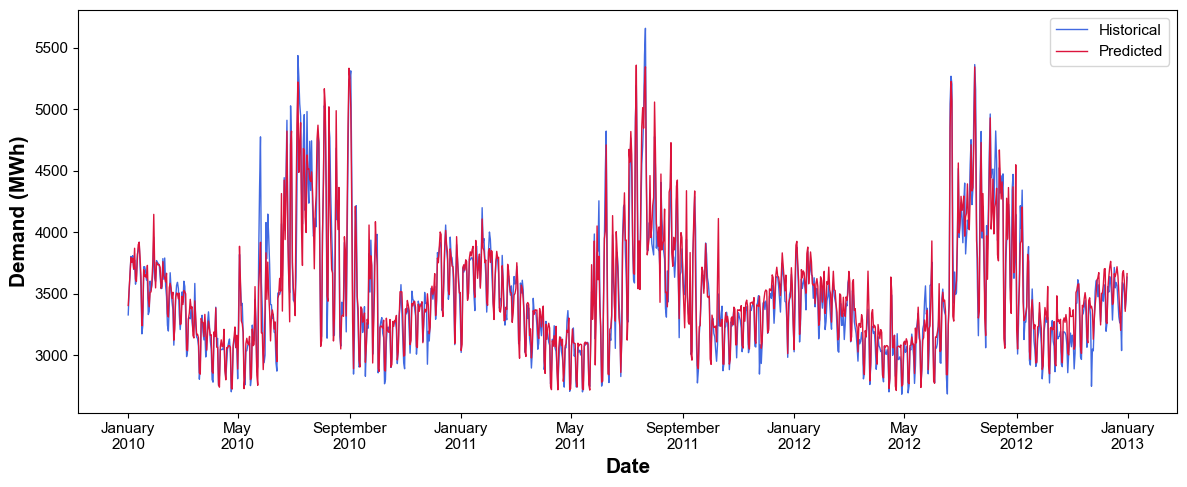

<Figure size 640x480 with 0 Axes>

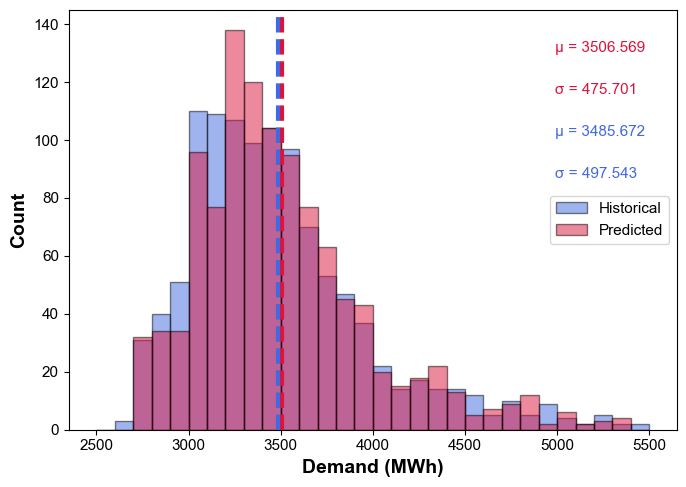

<Figure size 640x480 with 0 Axes>

In [36]:
#Defining the predictors and target variable
training_dataset = Organized_data.loc[Organized_data['Year']<2010].copy()
testing_dataset = Organized_data.loc[(Organized_data['Year']>=2010) & (Organized_data['Year']<2013)].copy()

X_train = training_dataset[['DayOfYear', 'WeekdayOrWeekend', 'WindSpeed', 'CDD', 'HDD']]
y_train = training_dataset['Demand']

X_test = testing_dataset[['DayOfYear', 'WeekdayOrWeekend', 'WindSpeed', 'CDD', 'HDD']]
y_test = testing_dataset['Demand']

#Defining best parameters
best_params = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}

#Initializing the GradientBoostingRegressor with the best hyperparameters
gb_model = GradientBoostingRegressor(random_state=12345, **best_params)

#Fitting the model
gb_model.fit(X_train, y_train)

#Making predictions
y_pred = gb_model.predict(X_test)

#Plotting the comparison timeseries
plt.rcParams.update({'font.size': 11})
plt.rcParams['font.sans-serif'] = "Arial"

fig, ax = plt.subplots(figsize=(12,5))

ax.plot(testing_dataset["Date"], y_test, label='Historical', color='royalblue', lw=1)
ax.plot(testing_dataset["Date"], y_pred, label='Predicted', color='crimson', lw=1)

ax.legend(loc='best')
ax.set_ylabel('Demand (MWh)', weight='bold', fontsize=15)
ax.set_xlabel('Date', weight='bold', fontsize=15)
ax.set_xticks(['2010-01-01', '2010-05-01', '2010-09-01', '2011-01-01', '2011-05-01', '2011-09-01', '2012-01-01', '2012-05-01', '2012-09-01','2013-01-01'])
ax.set_xticklabels(['January\n2010', 'May\n2010', 'September\n2010', 'January\n2011', 'May\n2011', 'September\n2011', 'January\n2012', 'May\n2012', 'September\n2012', 'January\n2013'])

plt.tight_layout()
plt.show()
plt.clf()


#Calculating mean and standard deviation of demands
sim_mean = round(np.mean(y_pred),3)
hist_mean = round(np.mean(y_test),3)

sim_std = round(np.std(y_pred),3)
hist_std = round(np.std(y_test),3)

#Plotting histogram comparison
fig, ax = plt.subplots(figsize=(7,5))

ax.hist(y_test, color='royalblue',edgecolor='black',linewidth=1, label='Historical',alpha=0.5, bins=[*range(2500,5501,100)])
ax.hist(y_pred, color='crimson',edgecolor='black',linewidth=1, label='Predicted',alpha=0.5, bins=[*range(2500,5501,100)])
ax.axvline(sim_mean, color='crimson', linestyle='--',linewidth=3)
ax.axvline(hist_mean, color='royalblue', linestyle='--',linewidth=3)
ax.annotate(u"\u03bc = {}".format(sim_mean), xy=(0.8, 0.9), xycoords='axes fraction', color='crimson')
ax.annotate(u'\u03C3 = {}'.format(sim_std), xy=(0.8, 0.8), xycoords='axes fraction', color='crimson')
ax.annotate(u"\u03bc = {}".format(hist_mean), xy=(0.8, 0.7), xycoords='axes fraction', color='royalblue')
ax.annotate(u'\u03C3 = {}'.format(hist_std), xy=(0.8, 0.6), xycoords='axes fraction', color='royalblue')
ax.set_xlabel("Demand (MWh)", weight = 'bold', fontsize=14)
ax.set_ylabel("Count", weight = 'bold', fontsize=14)
ax.legend(loc='center right')

plt.tight_layout()
plt.show()
plt.clf()

From the above figures, we can see that our GradientBoostingRegressor can estimate the daily maximum electricity demand reasonably well. Average and standard deviations of estimated and historical demands are also really close. As next steps, we can create more advanced models like Multi-layer Perceptron (MLP) and/or include additional predictors to increase the accuracy of our electricity demand model. 